## load Model
---

In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.models import Model as Kerasmodel

%load_ext autoreload
%autoreload 2

original_model = tf.keras.models.load_model("/home/jovyan/models/origin/BirdNET-Analyzer/checkpoints/V2.1/BirdNET_GLOBAL_2K_V2.1_Model/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Eval

In [102]:
original_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 ADVANCED_SPEC1 (LinearSpec  (None, 128, 513, 1)          1         ['INPUT[0][0]']               
 Layer)                                                                                           
                                                                                                  
 BNORM_SPEC_NOQUANT (BatchN  (None, 128, 513, 1)          4         ['ADVANCED_SPEC1[0][0]']      
 ormalization)                                                                                    
                                                                                              

## Remove last layer and save
---

In [30]:
no_class_model = Kerasmodel(original_model.input, original_model.layers[-2].output)
no_class_model_path = "/home/jovyan/models/checkpoints_/no_class_model.tflite"

# Convert the keras model to a tflite
converter = tf.lite.TFLiteConverter.from_keras_model(no_class_model)
tflite_no_class_model = converter.convert()

print("Finished Converting")

with open(no_class_model_path, 'wb') as f:
    f.write(tflite_no_class_model)
print("Finished Saving")

INFO:tensorflow:Assets written to: /tmp/tmpafu3j7co/assets


INFO:tensorflow:Assets written to: /tmp/tmpafu3j7co/assets
2023-09-22 12:53:46.328669: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-22 12:53:46.328773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-22 12:53:46.329108: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpafu3j7co
2023-09-22 12:53:46.354258: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-22 12:53:46.354324: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpafu3j7co
2023-09-22 12:53:46.437292: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-22 12:53:46.815366: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpafu3j7co
2023-09-22 12:53:46.967144: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Finished Converting
Finished Saving


## Load training data
---

In [3]:
import data as data


train_data_path = "/home/jovyan/cut-data/training/"

# Load training data
print('Loading training data...', flush=True)
x_train, y_train, labels, file_paths_train = data.loadData(train_data_path)
print('...Done. Loaded {} training samples and {} labels.'.format(x_train.shape[0], y_train.shape[1]), flush=True)

Loading training data...
Processed 0 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0001_127764.wav
Processed 100 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0003_82178411.wav
Processed 200 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0006_718263.wav
Processed 300 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0010_540556.wav
Processed 400 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0016_324707.wav
Processed 500 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0022_355153.wav
Processed 600 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0031_270434051.wav
Processed 700 files. Currently processing file: /home/jovyan/cut-data/training/non_target/0.920_0043_647427.wav
Processed 800 files. Currently processing file: /home/jovyan/cut-data/traini

In [4]:
import numpy as np

# balance the training data:
print('Balance the training data...')

y_train_indices = np.argmax(y_train, axis=1)

# minimum of one class
min_samples = min(np.bincount(y_train_indices))

# reduce entries until minimum after shuffle 
balanced_x_train = []
balanced_y_train = []
balanced_file_paths_train = []
for label in np.unique(y_train_indices):
    indices = np.where(y_train_indices == label)[0]
    np.random.shuffle(indices)  # Random order for random removal of samples
    indices = indices[:min_samples]
    balanced_x_train.append(x_train[indices])
    balanced_y_train.append(y_train[indices])
    balanced_file_paths_train.extend(file_paths_train[indices])

# Combine the balanced data for all classes
balanced_x_train = np.concatenate(balanced_x_train, axis=0)
balanced_y_train = np.concatenate(balanced_y_train, axis=0)
balanced_file_paths_train = np.array(balanced_file_paths_train)

print('Balanced training data:')
print('x_train shape:', balanced_x_train.shape)
print('y_train shape:', balanced_y_train.shape)
print('file_paths_train shape:', balanced_file_paths_train.shape)

print('...Done. Loaded {} training samples and {} labels.'.format(balanced_x_train.shape[0], balanced_y_train.shape[0]), flush=True)

Balance the training data...
Balanced training data:
x_train shape: (7612,)
y_train shape: (7612, 2)
file_paths_train shape: (7612,)
...Done. Loaded 7612 training samples and 7612 labels.


## Load validation data and convert
---

In [5]:
val_data_path = "/home/jovyan/cut-data/validation/"

print('Loading validation data...', flush=True)
x_val, y_val, labels, file_paths_val = data.loadData(val_data_path)
print('...Done. Loaded {} validation samples and {} labels.'.format(x_val.shape[0], y_val.shape[1]), flush=True)

Loading validation data...
Processed 0 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/0.920_0001_270097.wav
Processed 100 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/0.930_0002_182583971.wav
Processed 200 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/0.940_0004_534761.wav
Processed 300 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/0.950_0018_226391901.wav
Processed 400 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/0.970_0017_647758.wav
Processed 500 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/1.000_0001_0H2uMhzSitY_520.wav
Processed 600 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/1.000_0002_--ivFZu-hlc_30.wav
Processed 700 files. Currently processing file: /home/jovyan/cut-data/validation/non_target/1.000_0002_2RpOd9MJjyQ_10.wav
Processed 800 files. Currently p

In [6]:
# Convert to numpy arrays

import numpy as np

x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')

x_val = np.array(x_val, dtype='float32')
y_val = np.array(y_val, dtype='float32')

print('...Done. Loaded {} training files and {} labels.'.format(x_train.shape[0], y_train.shape[1]), flush=True)
print('...Done. Loaded {} validation files and {} labels.'.format(x_val.shape[0], y_val.shape[1]), flush=True)

...Done. Loaded 11292 training files and 2 labels.
...Done. Loaded 1381 validation files and 2 labels.


## Create new 2 Class Model
---

## Build custom classifier
---

In [99]:
import model

train_hidden_units = 0

# Build two class model
print('Building model...', flush=True)    
two_class_model_softmax = model.addLinearClassifier(no_class_model,
                                            y_train.shape[1], #number of labels
                                            train_hidden_units) #number of hidden units

print('...Done.', flush=True)

Building model...
...Done.


### check new shape

In [8]:
two_class_model_softmax.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 ADVANCED_SPEC1 (LinearSpec  (None, 128, 513, 1)          1         ['INPUT[0][0]']               
 Layer)                                                                                           
                                                                                                  
 BNORM_SPEC_NOQUANT (BatchN  (None, 128, 513, 1)          4         ['ADVANCED_SPEC1[0][0]']      
 ormalization)                                                                                    
                                                                                            

# Train Two Class Model
---

## Train Model
---

### NaN Debug (not active)

#### Trainingsdata

In [8]:
# import model
# # Disable Model Debug
# tf.debugging.disable_check_numerics()

# nan_samples = model.debug_model(two_class_model, file_paths_train, y_train, train_batch_size)

#### Validationdata

In [9]:
# import model
# # Disable Model Debug
# tf.debugging.disable_check_numerics()

# nan_samples = model.debug_model(two_class_model, file_paths_val, y_val, train_batch_size)

### Actual Training

In [9]:
train_epochs = 5
train_batch_size = 12
train_learning_rate = 0.0001
    
# Number of last layers to be trained, rest will be frozen, 0 = alle will be trained
train_layers_num = 2

on_epoch_end = None

print("Shape of training labels: ", x_train.shape)
print("Shape of validation labels: ", x_val.shape)

Shape of training labels:  (11292,)
Shape of validation labels:  (1381,)


In [68]:
# Train model
print('Training model...', flush=True)

# Check for Errors to find NaN problem
# tf.debugging.enable_check_numerics()

# Disable Model Debug
tf.debugging.disable_check_numerics()

trained_two_class_model_softmax, history = model.trainNewModel(
                                      two_class_model_softmax,
                                      train_layers_num,
                                      balanced_x_train, 
                                      balanced_y_train,
                                      x_val,
                                      y_val,
                                      balanced_file_paths_train,
                                      file_paths_val,
                                      epochs=train_epochs,
                                      batch_size=train_batch_size,
                                      learning_rate=train_learning_rate,
                                      on_epoch_end=on_epoch_end)

print('Done', flush=True)

Training model...
Length of trainable Weightslen  2
Epoch 1/5
476/476 [==============================] - 225s 465ms/step - loss: 0.4348 - accuracy: 0.9182 - prec: 0.9182 - recall: 0.9182 - val_loss: 0.2716 - val_accuracy: 0.9971 - val_prec: 0.9971 - val_recall: 0.9971
Epoch 2/5
476/476 [==============================] - 127s 267ms/step - loss: 0.2029 - accuracy: 0.9989 - prec: 0.9989 - recall: 0.9989 - val_loss: 0.1519 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 3/5
476/476 [==============================] - 129s 272ms/step - loss: 0.1331 - accuracy: 0.9999 - prec: 0.9999 - recall: 0.9999 - val_loss: 0.1141 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 4/5
476/476 [==============================] - 130s 274ms/step - loss: 0.1091 - accuracy: 0.9999 - prec: 0.9999 - recall: 0.9999 - val_loss: 0.1017 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 5/5
476/476 [==============================] - 131s 275ms/step - loss: 0.1

### Plot first Epoch

In [49]:
dir(history.on_batch_end)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_is_default',
 '_tf_docs_tools_for_subclass_implementers']

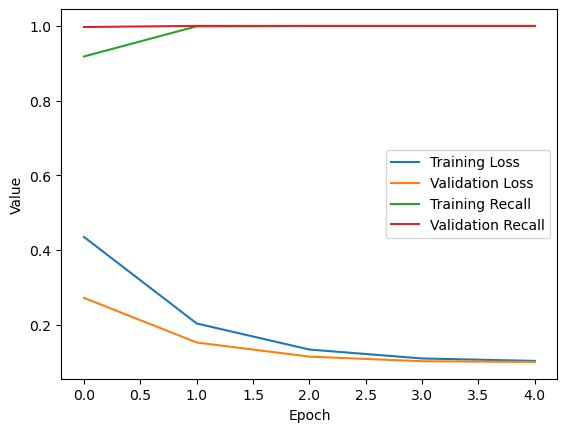

In [85]:
import matplotlib.pyplot as plt
import os



# Loss curve
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')

# Recall curve
plt.plot(history.epoch, history.history['recall'], label='Training Recall')
plt.plot(history.epoch, history.history['val_recall'], label='Validation Recall')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()


image_folder = 'Image'
os.makedirs(image_folder, exist_ok=True)

image_path = os.path.join(image_folder, 'loss_recall_plot_clipping')
plt.savefig(f"{image_path}.pdf")


plt.show()




### TESTING

In [12]:
import evaluateModel

test_data_path = "/home/jovyan/cut-data/testing/"

evaluateModel.evaluateModel(trained_two_class_model_softmax, test_data_path, train_batch_size)


Processed 0 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/0.920_0001_703520.wav
Processed 100 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/0.920_0057_645986.wav
Processed 200 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/0.930_0263_741788.wav
Processed 300 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/0.950_0002_645965.wav
Processed 400 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/0.960_0024_103739801.wav
Processed 500 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/1.000_0001_-X5Ay0Wuew0_20.wav
Processed 600 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/1.000_0001_4TQzd0lB8IQ_30.wav
Processed 700 files. Currently processing file: /home/jovyan/cut-data/testing/non_target/1.000_0002_1MF9_29YUZU_10.wav
Processed 800 files. Currently processing file: /home/jovyan/cut-data/testing/non_targe

### SAVE
---

#### Save Baseline Model with last Activation Layer

In [15]:
tflite_baselineModel_activation_path = "/home/jovyan/models/checkpoints_/baseline_two_class_model_softmax_activation.tflite"
keras_baselineModel_activation_path = "/home/jovyan/models/checkpoints_/baseline_two_class_model_softmax_activation/"

baselineModel_activation_softmax = trained_two_class_model_softmax

baselineModel_activation_softmax.summary()

# Save the model to a keras model
baselineModel_activation_softmax.save(keras_baselineModel_activation_path)
print("Finished Keras File save")

# Convert the keras model to a tflite
converter = tf.lite.TFLiteConverter.from_keras_model(baselineModel_activation_softmax)
tflite_baselineModel_activation_softmax = converter.convert()

print("Finished Converting")

with open(tflite_baselineModel_activation_path, 'wb') as f:
    f.write(tflite_baselineModel_activation_softmax)
print("Finished Saving")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 ADVANCED_SPEC1 (LinearSpec  (None, 128, 513, 1)          1         ['INPUT[0][0]']               
 Layer)                                                                                           
                                                                                                  
 BNORM_SPEC_NOQUANT (BatchN  (None, 128, 513, 1)          4         ['ADVANCED_SPEC1[0][0]']      
 ormalization)                                                                                    
                                                                                            

INFO:tensorflow:Assets written to: /home/jovyan/models/checkpoints_/baseline_two_class_model_softmax_activation/assets


Finished Keras File save
INFO:tensorflow:Assets written to: /tmp/tmphehizlz4/assets


INFO:tensorflow:Assets written to: /tmp/tmphehizlz4/assets
2023-08-31 09:34:58.283324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-31 09:34:58.283390: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-31 09:34:58.283704: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphehizlz4
2023-08-31 09:34:58.328820: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-31 09:34:58.328877: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmphehizlz4
2023-08-31 09:34:58.434187: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-31 09:34:58.881912: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmphehizlz4
2023-08-31 09:34:59.087488: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Finished Converting
Finished Saving


#### Eval saved tfLite Model

In [ ]:
import evaluateTFliteModel

tflite_baselineModel_activation_path = "/home/jovyan/models/checkpoints_/baseline_two_class_model_activation.tflite"
test_data_path = "/home/jovyan/cut-data/testing/"

batch_size = 12

evaluateTFliteModel.evaluate_tflite_model(tflite_baselineModel_activation_path, test_data_path, batch_size)

## Without clipnorm and clipvalues
---

### Training

In [100]:
train_epochs = 5
train_batch_size = 12
train_learning_rate = 0.0001
    
# Number of last layers to be trained, rest will be frozen, 0 = alle will be trained
train_layers_num = 2

on_epoch_end = None

print("Shape of training labels: ", x_train.shape)
print("Shape of validation labels: ", x_val.shape)

Shape of training labels:  (11292,)
Shape of validation labels:  (1381,)


In [101]:
# Train model
print('Training model...', flush=True)

trained_two_class_model_softmax_noclip, history_noclip = model.trainNewModel(
                                      two_class_model_softmax,
                                      train_layers_num,
                                      balanced_x_train, 
                                      balanced_y_train,
                                      x_val,
                                      y_val,
                                      balanced_file_paths_train,
                                      file_paths_val,
                                      epochs=train_epochs,
                                      batch_size=train_batch_size,
                                      learning_rate=train_learning_rate,
                                      on_epoch_end=on_epoch_end)

print('Done', flush=True)

Training model...
Length of trainable Weightslen  2
No clipping
Epoch 1/5
635/635 [==============================] - 155s 239ms/step - loss: 0.5825 - accuracy: 0.7788 - prec: 0.7788 - recall: 0.7788 - val_loss: 0.3923 - val_accuracy: 0.9508 - val_prec: 0.9508 - val_recall: 0.9508
Epoch 2/5
635/635 [==============================] - 150s 236ms/step - loss: 0.2844 - accuracy: 0.9915 - prec: 0.9915 - recall: 0.9915 - val_loss: 0.2259 - val_accuracy: 0.9978 - val_prec: 0.9978 - val_recall: 0.9978
Epoch 3/5
635/635 [==============================] - 149s 235ms/step - loss: 0.1842 - accuracy: 0.9982 - prec: 0.9982 - recall: 0.9982 - val_loss: 0.1609 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 4/5
635/635 [==============================] - 149s 235ms/step - loss: 0.1479 - accuracy: 0.9996 - prec: 0.9996 - recall: 0.9996 - val_loss: 0.1419 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 5/5
635/635 [==============================] - 146s 229ms/step

### Evaluate

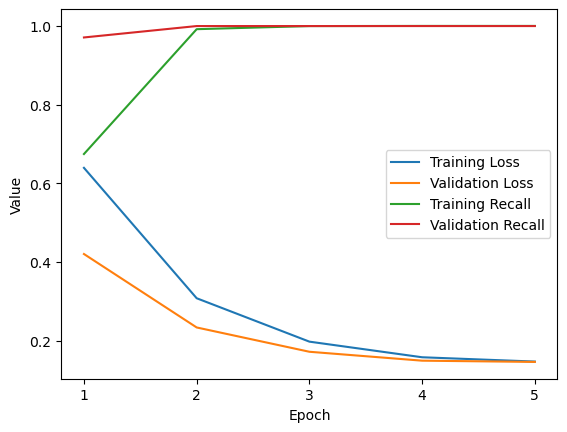

In [84]:
import matplotlib.pyplot as plt2
import os

# Loss curve
plt2.plot([1 + i for i in history_noclip.epoch], history_noclip.history['loss'], label='Training Loss')
plt2.plot([1 + i for i in history_noclip.epoch], history_noclip.history['val_loss'], label='Validation Loss')

# Recall curve
plt2.plot([1 + i for i in history_noclip.epoch], history_noclip.history['recall'], label='Training Recall')
plt2.plot([1 + i for i in history_noclip.epoch], history_noclip.history['val_recall'], label='Validation Recall')

# x-axis values
plt2.xticks([1, 2, 3, 4, 5])

plt2.xlabel('Epoch')
plt2.ylabel('Value')
plt2.legend()


image_folder = 'Image'
os.makedirs(image_folder, exist_ok=True)

image_path = os.path.join(image_folder, 'loss_recall_plot_noclipping')
plt2.savefig(f"{image_path}.pdf")


plt2.show()

## Batchsize 16
---

### Create 2 Class Model

In [86]:
import model

train_hidden_units = 0

# Build two class model
print('Building model...', flush=True)    
two_class_model_softmax = model.addLinearClassifier(no_class_model,
                                            y_train.shape[1], #number of labels
                                            train_hidden_units) #number of hidden units

print('...Done.', flush=True)

Building model...
...Done.


### Training

In [87]:
train_epochs = 5
train_batch_size = 16
train_learning_rate = 0.0001
    
# Number of last layers to be trained, rest will be frozen, 0 = alle will be trained
train_layers_num = 2

on_epoch_end = None

print("Shape of training labels: ", x_train.shape)
print("Shape of validation labels: ", x_val.shape)

Shape of training labels:  (11292,)
Shape of validation labels:  (1381,)


In [88]:
# Train model
print('Training model...', flush=True)

trained_two_class_model_softmax_16_batch, history_16_batch = model.trainNewModel(
                                      two_class_model_softmax,
                                      train_layers_num,
                                      balanced_x_train, 
                                      balanced_y_train,
                                      x_val,
                                      y_val,
                                      balanced_file_paths_train,
                                      file_paths_val,
                                      epochs=train_epochs,
                                      batch_size=train_batch_size,
                                      learning_rate=train_learning_rate,
                                      on_epoch_end=on_epoch_end)

print('Done', flush=True)

Training model...
Length of trainable Weightslen  2
Epoch 1/5
476/476 [==============================] - 230s 476ms/step - loss: 0.5998 - accuracy: 0.7760 - prec: 0.7760 - recall: 0.7760 - val_loss: 0.3459 - val_accuracy: 0.9877 - val_prec: 0.9877 - val_recall: 0.9877
Epoch 2/5
476/476 [==============================] - 125s 263ms/step - loss: 0.2516 - accuracy: 0.9949 - prec: 0.9949 - recall: 0.9949 - val_loss: 0.1845 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 3/5
476/476 [==============================] - 125s 263ms/step - loss: 0.1587 - accuracy: 0.9999 - prec: 0.9999 - recall: 0.9999 - val_loss: 0.1319 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 4/5
476/476 [==============================] - 124s 261ms/step - loss: 0.1286 - accuracy: 1.0000 - prec: 1.0000 - recall: 1.0000 - val_loss: 0.1182 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_recall: 1.0000
Epoch 5/5
476/476 [==============================] - 126s 264ms/step - loss: 0.1

### Evaluate

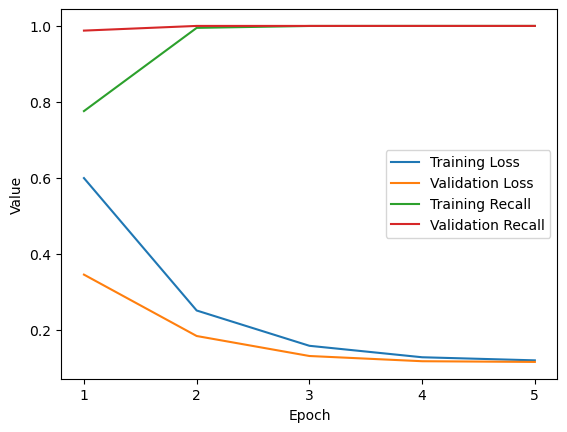

In [89]:
import matplotlib.pyplot as plt3
import os

# Loss curve
plt3.plot([1 + i for i in history_16_batch.epoch], history_16_batch.history['loss'], label='Training Loss')
plt3.plot([1 + i for i in history_16_batch.epoch], history_16_batch.history['val_loss'], label='Validation Loss')

# Recall curve
plt3.plot([1 + i for i in history_16_batch.epoch], history_16_batch.history['recall'], label='Training Recall')
plt3.plot([1 + i for i in history_16_batch.epoch], history_16_batch.history['val_recall'], label='Validation Recall')

# Festlegen der xticks für die Epochs
plt3.xticks([1, 2, 3, 4, 5])

plt3.xlabel('Epoch')
plt3.ylabel('Value')
plt3.legend()


image_folder = 'Image'
os.makedirs(image_folder, exist_ok=True)

image_path = os.path.join(image_folder, 'loss_recall_plot_16batch')
plt2.savefig(f"{image_path}.pdf")


plt2.show()